<a href="https://colab.research.google.com/github/armiro/canine-disease-diagnosis/blob/main/model_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## libraries and data importing

In [ ]:
# update sklearn package to v0.24.x which is the latest version
!pip install --upgrade scikit-learn
# install shap library to draw fancy model explainations
!pip install shap

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, ShuffleSplit

In [3]:
dataset = pd.read_csv("/content/canine_chemical_dataset_v1.6.csv")
print(dataset.head())

features = dataset.iloc[:, :30]
labels = dataset.iloc[:, 30:]

              Species   Age  ... Volume depletion  hepatocellular injury
0       HERDING GROUP  10.0  ...                0                      0
1  NON-SPORTING GROUP  13.0  ...                0                      0
2       WORKING GROUP   1.0  ...                0                      0
3       HERDING GROUP   6.0  ...                0                      0
4       HERDING GROUP   3.0  ...                0                      0

[5 rows x 244 columns]


## EDA: feature correlation detection

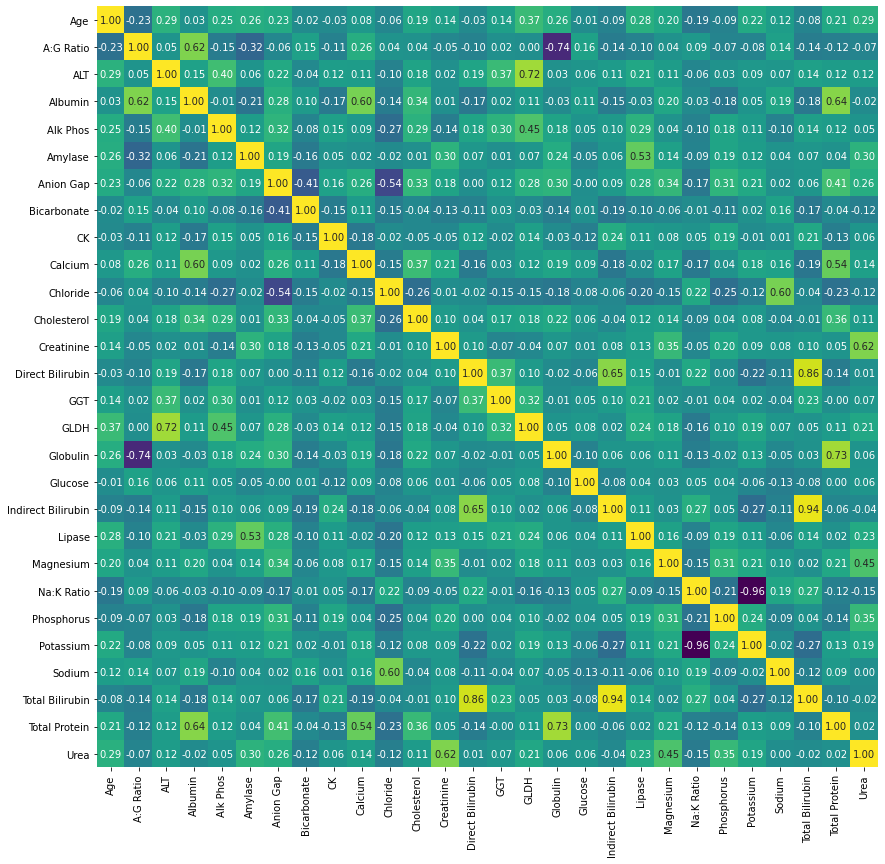

In [ ]:
corr_mat = features.corr()
fig = plt.figure(figsize=(14, 14))
sns.heatmap(corr_mat, xticklabels=corr_mat.columns, yticklabels=corr_mat.columns, 
            cmap='viridis', annot=True, fmt='.2f', cbar=False)

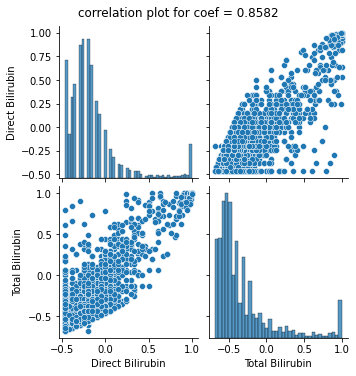

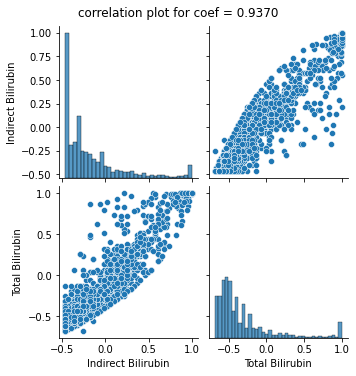

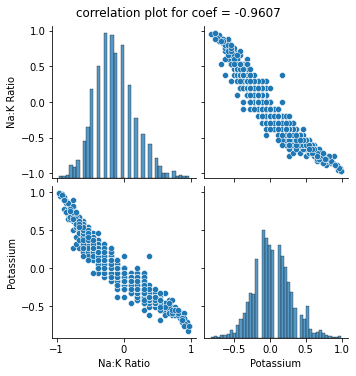

In [ ]:
for r_idx, row in enumerate(corr_mat.values):
    for c_idx, e in enumerate(row[r_idx+1:]):
        if ((e >= 0.8) | (e <= -0.8)) & (r_idx != c_idx):
            plt.rcParams['figure.figsize'] = (5,5)
            sub_df = features[[features.columns[r_idx+2], features.columns[c_idx+r_idx+3]]]
            cp = sns.pairplot(sub_df)
            cp.fig.suptitle("correlation plot for coef = %.4f" % e, y=1.03)
            plt.show()

according to the correlation map, we have some features which have high level of correlations. We must perform feature engineering (dim. reduction using PCA or creating new feature based on correlated ones) on some of the input features

## EDA: label correlation detection and reduction strategies

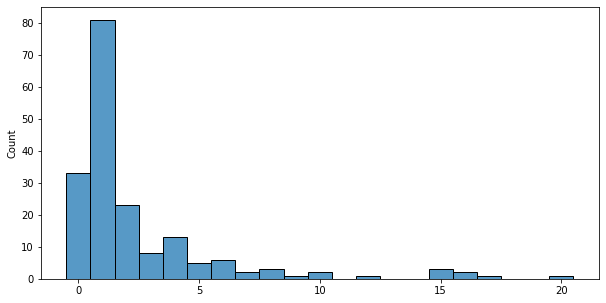

In [ ]:
# one last prep step for labels: we have too many (214) labels which could be shrunken
# to much smaller number of labels. we have to let go of labels with few occurances
label_freqs = list()
label_names = list()
for label, column in labels.iteritems():
    label_names.append(label)
    label_freqs.append(np.sum(column))

fig = plt.figure(figsize=(10, 5))
sns.histplot(label_freqs, discrete=True, binrange=(0, 20)) # hist for least frequent
plt.show()

which threshold? we can omit labels with freq < 5 (then change later to see differences). on average, each label is happen 26.5 times.

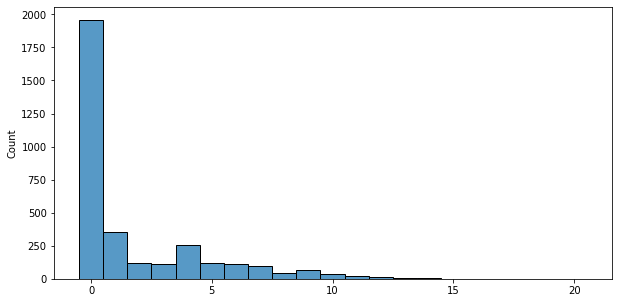

In [ ]:
# having labels that never happen (freq = 0) is weird. Let's see how many labels are
# activated for each record
num_activated_labels = list()
for row_idx, row in labels.iterrows():
    num_activated_labels.append(np.sum(row))

fig = plt.figure(figsize=(10, 5))
sns.histplot(num_activated_labels, discrete=True, binrange=(0, 20)) # hist for least frequent
plt.show()

we can see that many records have no activated labels! on average, each record has 1.78 activated labels. Since records with no activated labels mean the canine breed is healthy, we certainly keep these records.
actually, since we have 1958 healthy records out of 3329 samples, we can do a binary disease detection at first and perform disease classification on unhealthy predictions. (hierarchical classification) 

In [ ]:
drop_list = list()
for label, column in labels.iteritems():
    if np.sum(column) < 5: # omit labels with less than 5 occurances
        drop_list.append(label)

labels = labels.drop(columns=drop_list).values
print('number of labels is reduced from %d to %d' % (len(label_names), len(labels[0])))

number of labels is reduced from 214 to 56


## model development

In [4]:
# construct feature transformation pipeline
ct = ColumnTransformer(
    [('onehot_encoder', OneHotEncoder(drop='first', sparse=False), [0, 2]),
     ('minmax_scaler', MinMaxScaler((0, 1)), [1])], # scale 'age' to [0,1]
    remainder='passthrough') # leave other columns untouched
features_encoded = ct.fit_transform(X=features)

### hierarchical classification

In [ ]:
# create new label: sick or not? (for binary classification)
is_sick = np.array([1.0 if np.sum(row) >= 1 else 0.0 for row in labels.values])
print('num pos values:', np.sum(is_sick))
print('num neg values:', len(is_sick) - np.sum(is_sick))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(is_sick), 
                                                  y=is_sick)
class_weights = dict({0: class_weights[0], 1: class_weights[1]})
pos_ratio = np.sum(is_sick) / (len(is_sick)-np.sum(is_sick))

In [ ]:
# perform outlier detection using automated methods
### not for now

In [5]:
# perform K-Fold cross-validation and find model scores on training/validation data
def get_results_of(model):
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=17)
    results = cross_validate(estimator=model, X=features_encoded, y=is_sick, cv=cv, 
                             scoring=['accuracy', 'roc_auc'])
    acc_scores = results['test_accuracy']
    print('mean cross-validation ACC is %.3f (std=%.3f) / best cross-validation ACC is %.3f' 
            % (abs(np.mean(acc_scores)), np.std(acc_scores), abs(np.max(acc_scores))))
    auc_scores = results['test_roc_auc']
    print('mean cross-validation ROC AUC is %.3f (std=%.3f) / best cross-validation ROC AUC is %.3f' 
            % (abs(np.mean(auc_scores)), np.std(auc_scores), abs(np.max(auc_scores))))

In [ ]:
from sklearn.svm import SVC
params = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'), 'C': [0.1, 1, 10], 
          'degree': [1, 2, 3, 4]}
base_clf = SVC(class_weight=class_weights)
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=17)
clfs = GridSearchCV(estimator=base_clf, param_grid=params, cv=cv)
clfs.fit(features_encoded, is_sick)
print('best observed parameters for SVM Clf:', clfs.best_params_)
get_results_of(model=clfs.best_estimator_)
print('-----------------------------------------------------')


from sklearn.tree import DecisionTreeClassifier
params = {'max_depth': [2, 3, 4, 5], 'criterion': ['gini', 'entropy']}
base_clf = DecisionTreeClassifier(class_weight=class_weights)
clfs = GridSearchCV(estimator=base_clf, param_grid=params, cv=cv)
clfs.fit(features_encoded, is_sick)
print('best observed parameters for DecisionTree Clf:', clfs.best_params_)
get_results_of(model=clfs.best_estimator_)
print('-----------------------------------------------------')


from sklearn.linear_model import LogisticRegression
params = {'C': [0.1, 1.0, 2.0, 10.0], 'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
base_clf = LogisticRegression(class_weight=class_weights)
clfs = GridSearchCV(estimator=base_clf, param_grid=params, cv=cv)
clfs.fit(features_encoded, is_sick)
print('best observed parameters for LogReg Clf:', clfs.best_params_)
get_results_of(model=clfs.best_estimator_)
print('-----------------------------------------------------')


from sklearn.ensemble import RandomForestClassifier
params = {'max_depth': [2, 3, 4, 5], 'criterion': ['gini', 'entropy'],
          'n_estimators': [20, 50, 100, 200]}
base_clf = RandomForestClassifier(class_weight=class_weights)
clfs = GridSearchCV(estimator=base_clf, param_grid=params, cv=cv)
clfs.fit(features_encoded, is_sick)
print('best observed parameters for RF Clf:', clfs.best_params_)
get_results_of(model=clfs.best_estimator_)
print('-----------------------------------------------------')


import xgboost as xgb
params = {'max_depth': [2, 3, 4, 5], 'n_estimators': [20, 50, 100, 200]}
base_clf = xgb.XGBClassifier(scale_pos_weight=1/pos_ratio)
clfs = GridSearchCV(estimator=base_clf, param_grid=params, cv=cv)
clfs.fit(features_encoded, is_sick)
print('best observed parameters for XGB Clf:', clfs.best_params_)
get_results_of(model=clfs.best_estimator_)

best observed parameters for SVM Clf: {'C': 0.1, 'degree': 4, 'kernel': 'poly'}
mean cross-validation ACC is 0.599 (std=0.015) / best cross-validation ACC is 0.637
mean cross-validation ROC AUC is 0.601 (std=0.025) / best cross-validation ROC AUC is 0.653
-----------------------------------------------------
best observed parameters for DecisionTree Clf: {'criterion': 'gini', 'max_depth': 2}
mean cross-validation ACC is 0.593 (std=0.020) / best cross-validation ACC is 0.622
mean cross-validation ROC AUC is 0.616 (std=0.024) / best cross-validation ROC AUC is 0.645
-----------------------------------------------------
best observed parameters for LogReg Clf: {'C': 0.1, 'solver': 'newton-cg'}
mean cross-validation ACC is 0.589 (std=0.020) / best cross-validation ACC is 0.625
mean cross-validation ROC AUC is 0.614 (std=0.025) / best cross-validation ROC AUC is 0.651
-----------------------------------------------------
best observed parameters for RF Clf: {'criterion': 'gini', 'max_depth'

best model in terms of average ACC as well as AUC is (as expected) the **XGBoost classifier**

### flat classification of multi-label data

In [ ]:
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight(class_weight='balanced', 
#                                                   classes=np.unique(labels.values), 
#                                                   y=labels)
# print(class_weights)

In [5]:
# define multilabel classification metrics
def micro_avg_f1_score(y, yhat):
    return sklearn.metrics.f1_score(y, yhat, average='micro')

def alpha_evaluation_score(y, yhat):
    alpha = 1.0; beta = 1.0; gamma = 0.8 # FN is more important than FP, so beta > gamma
    # compute true positives across training examples and labels
    tp = np.sum(np.logical_and(y, yhat))
    # compute false negatives (Missed Labels) across training examples and labels
    fn = np.sum(np.logical_and(y, np.logical_not(yhat)))
    # compute False Positive across training examples and labels.
    fp = np.sum(np.logical_and(np.logical_not(y), yhat))
    # Compute alpha evaluation score
    alpha_score = (1 - ((beta*fn + gamma*fp) / (tp + fn + fp + 0.00001)))**alpha
    return alpha_score


metrics = {'micro_f1': sklearn.metrics.make_scorer(micro_avg_f1_score),
           'alpha_eval': sklearn.metrics.make_scorer(alpha_evaluation_score)}

In [104]:
# # perform K-Fold cross-validation and find model scores on training/validation data
# def get_results_of(model):
#     cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=17)
#     results = cross_validate(estimator=model, X=features_encoded, y=labels.values, cv=cv, 
#                              scoring=metrics)
#     # print(results)
#     f1_scores = results['test_micro_f1']
#     print('mean micro average f1 is %.3f (std=%.3f) / best micro average f1 is %.3f' 
#             % (abs(np.mean(f1_scores)), np.std(f1_scores), abs(np.max(f1_scores))))
#     alpha_scores = results['test_alpha_eval']
#     print('mean alpha is %.3f (std=%.3f) / best alpha is %.3f' 
#             % (abs(np.mean(alpha_scores)), np.std(alpha_scores), abs(np.max(alpha_scores))))

In [26]:
from sklearn.tree import DecisionTreeClassifier
# from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier

# clf = DecisionTreeClassifier(random_state=0)
# clf = MultiOutputClassifier(estimator=DecisionTreeClassifier(random_state=0))
clf = OneVsRestClassifier(estimator=DecisionTreeClassifier())

X_train, X_test, y_train, y_test = train_test_split(features_encoded, labels.values, 
                                                    test_size=0.1, random_state=0)

for idx, col_name in enumerate(labels.columns):
    print('classifying %s label:' % col_name)
    clf.fit(X_train, y_train[:, idx])
    preds = clf.predict(X_test)
    print('f1:', alpha_evaluation_score(y=y_test[:, idx], yhat=preds))

# clf.fit(X_train, y_train)
# preds = clf.predict(X_test)

# print('F1:', micro_avg_f1_score(y=y_test, yhat=preds))
# print('alpha:', alpha_evaluation_score(y=y_test, yhat=preds))

classifying 3rd space losses label:
f1: 0.13793133174781658
classifying AG acidosis  label:
f1: 1.0
classifying AG elevated label:
f1: 0.20000799992000085
classifying AG lowered label:
f1: 1.0
classifying ALP elvated label:
f1: 0.16470637370213315
classifying ALP lowered label:
f1: 1.0
classifying ALT elevated label:
f1: 0.11818221900808235
classifying ALT lowered label:
f1: 9.999900001056439e-06
classifying Acid base processes label:
f1: 1.0
classifying Acid gain label:
f1: 0.19333360222213247
classifying Acid-base disturbance label:
f1: 0.13333622221259256
classifying Addendum label:


/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))


f1: 1.0
classifying Addisonian label:
f1: 0.20000799992000085
classifying Albumin elevated label:
f1: 0.20000399998000007
classifying Albumin lowered label:
f1: 0.08571559183486865
classifying Alk phos elevation label:
f1: 9.999900001056439e-06
classifying Alk phos lowered label:
f1: 9.999900001056439e-06
classifying Alkalosis label:
f1: 1.0
classifying Alterations in portal circulation label:
f1: 1.0
classifying Altered lipid metabolism label:
f1: 0.29761913123581774
classifying Amylase elevated label:
f1: 9.999900001056439e-06
classifying Anal sac adenocarcinoma label:
f1: 1.0
classifying Anion gap acidosis label:
f1: 0.10000449997750016
classifying Anion gap elevated label:


/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))


f1: 0.22285736489789576
classifying Anorexic label:
f1: 0.20000799992000085
classifying Azotemia label:
f1: 0.0909099173546205
classifying Benign hepatic nodular hyperplasia label:
f1: 9.999900001056439e-06
classifying Benign nodular hyperplasia of liver label:
f1: 0.17435918606174716
classifying Bicarbonate elevated label:
f1: 1.0
classifying Bilateral hydronephrosis label:
f1: 1.0
classifying Bilirubin elevated label:
f1: 0.10000449997750016
classifying Blood losses label:
f1: 0.4666684444385185
classifying Body muscle mass/proportion label:
f1: 1.0
classifying Bone or steroid-induced isoforms label:
f1: 0.20000799992000085
classifying Brachycephalic syndrome label:
f1: 1.0
classifying CGT elevated label:
f1: 1.0
classifying CHF label:
f1: 1.0
classifying CK elevated label:
f1: 0.1739134026463467
classifying Calcium elevateed label:
f1: 1.0
classifying Chloride loss label:
f1: 1.0
classifying Cholestastic label:


/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))


f1: 0.1819820556772922
classifying Cholestatic disease label:
f1: 1.0
classifying Cholesterol.1 label:
f1: 0.06666977776740757
classifying Chronic kidney disease label:
f1: 1.0
classifying Chronic respiratory acidosis label:
f1: 1.0
classifying Concurrent cholestasis label:
f1: 0.05714420407970844
classifying Congenital abnormality label:
f1: 1.0
classifying Contraction of gall bladder label:
f1: 1.0
classifying Creatinine elevated label:
f1: 0.20000799992000085
classifying Creatinine lowered label:
f1: 0.2000015999967999
classifying Cushing label:
f1: 1.0
classifying Diabetes mellitus label:
f1: 1.0
classifying Diabetic hepatopathy label:
f1: 9.999900001056439e-06
classifying Diabetic ketoacidosis label:
f1: 9.999900001056439e-06
classifying Disorders of lipid metabolism label:
f1: 0.20000799992000085
classifying Diuresis label:
f1: 0.20000799992000085
classifying EPI label:


/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))


f1: 0.20000799992000085
classifying Ehrlichiosis label:
f1: 1.0
classifying Endocrine disorders label:
f1: 0.16000167999663995
classifying Endocrinopathy label:
f1: 0.28000008470587234
classifying Endoparasites label:
f1: 0.20000799992000085
classifying Enhanced tissue protein catabolism label:
f1: 1.0
classifying Fluid dilution label:
f1: 1.0
classifying Functional mass lowered label:
f1: 1.0
classifying GFR lowered label:
f1: 0.10000449997750016
classifying GGT elevated label:
f1: 0.20000799992000085
classifying GI lymphangiectasia label:
f1: 1.0
classifying GLDH elevated label:
f1: 0.17142896598620672
classifying GLDh lowered label:
f1: 1.0
classifying Gastrointestial losses label:
f1: 9.999900001056439e-06
classifying Gastrointestinal bleeding label:
f1: 0.3636369421482344
classifying Gastrointestinal disease label:
f1: 1.0
classifying Gastrointestinal losses label:


/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))


f1: 0.1428574489794825
classifying Gastrointestinal obstruction label:
f1: 0.20000799992000085
classifying Gastrointestinal stasis label:
f1: 1.0
classifying Gastrointestinal tract disease label:
f1: 1.0
classifying Globulins elevated label:
f1: 1.0
classifying Globulins lowered label:
f1: 1.0
classifying Glomerular disease label:
f1: 1.0
classifying Glomerular filtration rate lowered label:
f1: 0.06666822221962965
classifying Glomerular renal disease label:
f1: 1.0
classifying Glucocorticoid induction label:
f1: 1.0
classifying Glucocorticoid therapy label:
f1: 1.0
classifying Glucose elevated label:
f1: 1.0
classifying Glycosuria label:
f1: 1.0
classifying Hemoconcentration label:
f1: 0.20000799992000085
classifying Hemolysis.1 label:
f1: 0.20000399998000007
classifying Hemolytic process label:
f1: 1.0
classifying Hepatic disease label:
f1: 1.0
classifying Hepatic dysfunction label:
f1: 0.2137933745540087
classifying Hepatic enzymes elevated label:
f1: 0.28135605400744845
classifying

/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))


f1: 0.2848487015609995
classifying Hyperamylasemia label:
f1: 1.0
classifying Hyperbilirubinemia label:
f1: 0.20000399998000007
classifying Hypercalcemia label:
f1: 0.20000799992000085
classifying Hypercholesterolemia label:
f1: 0.3984127461577185
classifying Hypercortisolemia label:
f1: 0.20000799992000085
classifying Hyperglobulinemia label:
f1: 1.0
classifying Hyperglycemia label:
f1: 0.21666699305541948
classifying Hyperhcholesterolemia label:
f1: 0.20000799992000085
classifying Hyperkalemia label:
f1: 0.20000266665777766
classifying Hyperlipasemia label:
f1: 1.0
classifying Hypernatremia  label:
f1: 0.20000799992000085
classifying Hyperphosphatemia label:
f1: 0.06666977776740757
classifying Hyperproteinemia  label:
f1: 1.0
classifying HypoT4 label:
f1: 0.20000799992000085
classifying Hypoadrenocorticism label:
f1: 0.20000799992000085
classifying Hypoalbuminemic label:
f1: 0.2846156597632077
classifying Hypocalcemia  label:
f1: 0.20000799992000085
classifying Hypochloremia label:
f

/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))


f1: 0.20000799992000085
classifying Hypoxic injury label:
f1: 1.0
classifying IBD label:
f1: 0.20000799992000085
classifying Immunologic immaturity label:
f1: 1.0
classifying Induction label:
f1: 0.044445506171659765
classifying Infectious label:
f1: 1.0
classifying Inflammation label:
f1: 1.0
classifying Intestinal leakage label:
f1: 1.0
classifying Isoforms label:
f1: 1.0
classifying Isosthenuria label:
f1: 1.0
classifying Ketosis label:
f1: 1.0
classifying Lipase elevated label:
f1: 2.4999937499048386e-06
classifying Liver enzymes elevated label:
f1: 0.10000449997750016
classifying Liver insufficiency label:
f1: 1.0
classifying Lymphoma label:
f1: 1.0
classifying MCS/sarcopenia label:
f1: 1.0
classifying Metabolic acidosis label:
f1: 1.0
classifying Metabolic alkalosis label:
f1: 1.0
classifying Microalbuminuria label:
f1: 1.0
classifying Mild hypercholesteremia label:
f1: 1.0
classifying Muscle injury label:
f1: 0.31428604081617106
classifying Myocyte injury label:


/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))


f1: 1.0
classifying Myocyte leakage label:
f1: 1.0
classifying Neoplasia label:
f1: 1.0
classifying Neoplastic disease  label:
f1: 1.0
classifying Neoplastic etiology label:
f1: 0.20000399998000007
classifying Neoplastic involvement of liver label:
f1: 1.0
classifying Nodular hepatic hyperplasia label:
f1: 0.20000799992000085
classifying Normophosphatemic hypercalcemia label:
f1: 1.0
classifying PLN label:
f1: 1.0
classifying PU/PD label:
f1: 0.20000799992000085
classifying Pancreatic leakage label:
f1: 1.0
classifying Pancreatitis label:
f1: 0.05714420407970844
classifying Panhypoproteinemia label:
f1: 0.20000799992000085
classifying Pathological etiology label:
f1: 1.0
classifying Pathology label:
f1: 1.0
classifying Phenobarb therapy label:
f1: 1.0
classifying Phenobarbital Tx label:
f1: 0.20000799992000085
classifying Phenobarbital inductio label:
f1: 1.0
classifying Phosphorus elevated label:
f1: 1.0
classifying Polycystic kidney label:
f1: 0.20000799992000085
classifying Portosys

/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training example

f1: 1.0
classifying Selective hypochloremia label:
f1: 0.20000799992000085
classifying Sepsis label:
f1: 0.20000399998000007
classifying Sodium elevated label:
f1: 1.0
classifying Steroid-induction label:
f1: 0.2000001860464684
classifying Sub-optimal mineralocorticoid supplementation label:
f1: 1.0
classifying Systemic inflammation label:
f1: 0.20000799992000085
classifying Toxicity label:
f1: 1.0
classifying Tubulointerstitial disease label:
f1: 1.0
classifying UPC elevated label:
f1: 1.0
classifying UPC lowered label:
f1: 1.0
classifying UTI label:
f1: 1.0
classifying Urea elevated label:
f1: 0.2545461322307889
classifying Urea lowered label:
f1: 0.20000399998000007
classifying Volume contraction label:
f1: 0.20000799992000085
classifying Volume depletion label:
f1: 0.20000266665777766
classifying hepatocellular injury label:
f1: 1.0


/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:81: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))


In [ ]:
# from sklearn.tree import DecisionTreeClassifier

# params = {'max_depth': [2, 3, 4, 5], 'criterion': ['gini', 'entropy']}
# cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=17)
# base_clf = DecisionTreeClassifier()

# clfs = GridSearchCV(estimator=base_clf, param_grid=params, cv=cv)
# clfs.fit(features_encoded, labels.values)
# print('best observed parameters for DecisionTree Clf:', clfs.best_params_)
# get_results_of(model=clfs.best_estimator_)

## final model with result visualization

In [ ]:
from sklearn.metrics import confusion_matrix
clf = xgb.XGBClassifier(max_depth=2, scale_pos_weight=1/pos_ratio)

X_train, X_test, y_train, y_test = train_test_split(features_encoded, is_sick, test_size=0.2)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
print(confusion_matrix(y_true=y_train, y_pred=y_pred_train))
y_pred = clf.predict(X_test)
print(confusion_matrix(y_true=y_test, y_pred=y_pred))

[[1017  551]
 [ 313  782]]
[[228 162]
 [ 84 192]]


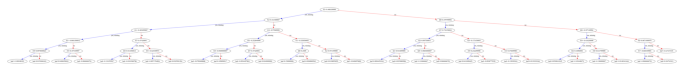

In [ ]:
xgb.plot_tree(booster=clfs.best_estimator_, num_trees=0)
plt.rcParams['figure.figsize'] = [12, 6]
plt.show()

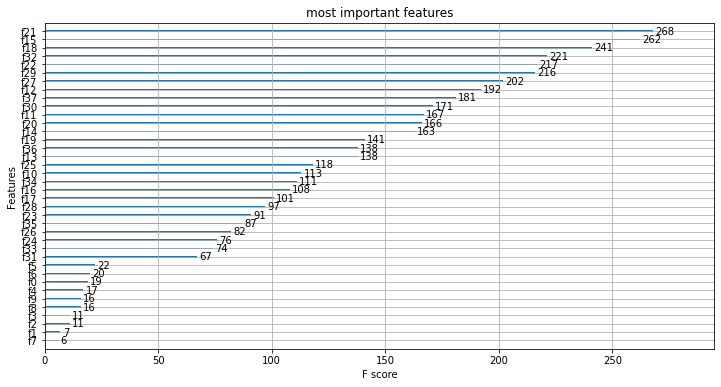

In [ ]:
xgb.plot_importance(booster=clfs.best_estimator_)
plt.rcParams['figure.figsize'] = [12, 6]
plt.title('most important features')
plt.show()

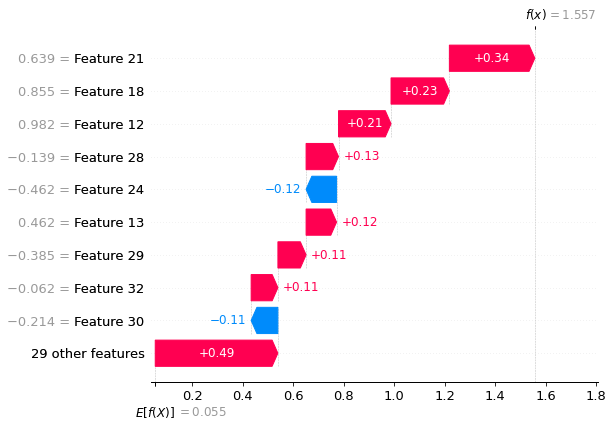

In [ ]:
import shap
explainer = shap.Explainer(model=clf)
shap_values = explainer(X=features_encoded, y=is_sick)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

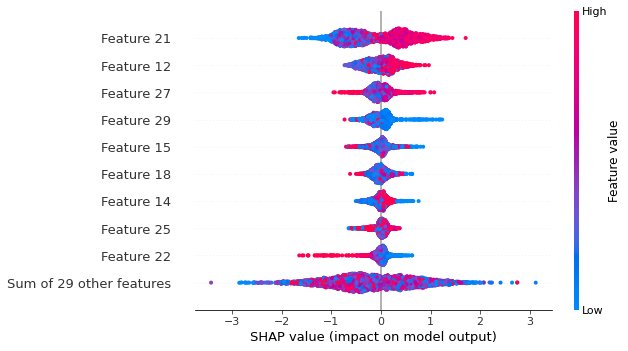

In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

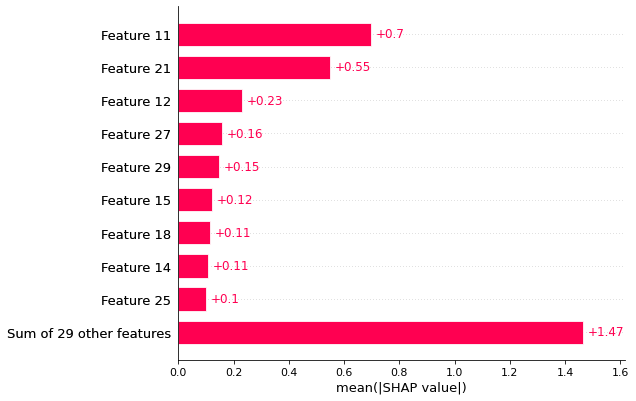

In [ ]:
shap.plots.bar(shap_values)